# Tree of trees with parameter tune

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime as dt
import importlib

import aux_funcs as aux

In [2]:
train = aux.read_train_data()

train.csv read in 9.1 s
Mem. usage decreased to 289.19 Mb (53.1% reduction)
(20216100, 11)
   building_id  meter  timestamp  meter_reading  hour  day  year  weeknumber  \
0            0      0 2016-01-01            0.0     0    1  2016          53   
1            1      0 2016-01-01            0.0     0    1  2016          53   
2            2      0 2016-01-01            0.0     0    1  2016          53   
3            3      0 2016-01-01            0.0     0    1  2016          53   
4            4      0 2016-01-01            0.0     0    1  2016          53   

   weekday  month  log_meter_reading  
0        4      1                0.0  
1        4      1                0.0  
2        4      1                0.0  
3        4      1                0.0  
4        4      1                0.0  


In [3]:
building = aux.read_building_data()

building_metadata.csv read in 0.1 s
Mem. usage decreased to  0.03 Mb (60.3% reduction)
(1449, 7)
   site_id  building_id primary_use  square_feet  year_built  floor_count  \
0        0            0   Education         7432      2008.0          NaN   
1        0            1   Education         2720      2004.0          NaN   
2        0            2   Education         5376      1991.0          NaN   
3        0            3   Education        23685      2002.0          NaN   
4        0            4   Education       116607      1975.0          NaN   

   log_square_feet  
0         8.913550  
1         7.908387  
2         8.589700  
3        10.072597  
4        11.666565  


In [4]:
weather_train = aux.read_weather_train_data()

weather_train.csv read in 0.2 s
Mem. usage decreased to  3.07 Mb (68.1% reduction)


In [5]:
weather_train.shape

(139773, 9)

In [6]:
weather_train.groupby('site_id')['timestamp'].count().to_frame()

,timestamp
site_id,
0,8784
1,8763
2,8783
3,8780
4,8783
5,8755
6,8782
7,8614
8,8784


In [7]:
aux.null_data_stats(weather_train)

,total,percentage
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
timestamp,0,0.000000
site_id,0,0.000000


In [8]:
sid = 0
wsid = weather_train.loc[weather_train['site_id']==sid]

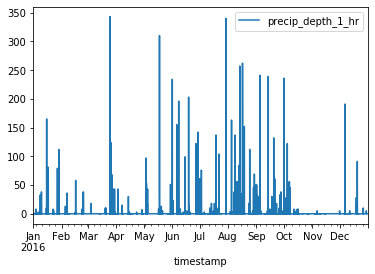

In [9]:
wsid.plot(x='timestamp',y='precip_depth_1_hr')

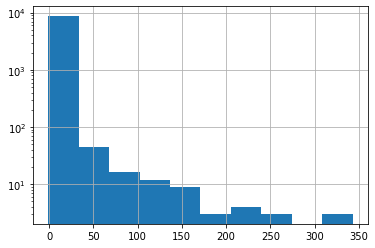

In [12]:
wsid['precip_depth_1_hr'].hist()
plt.yscale('log')

### join

In [14]:
tbw = train.join(building, on='building_id', rsuffix = 'r')

tbw.drop(columns=['year_built','floor_count','building_idr'],inplace=True)

In [15]:
tbw = pd.merge(tbw, weather_train,left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
tbw.head()

,building_id,meter,timestamp,meter_reading,hour,day,year,weeknumber,weekday,month,...,primary_use,square_feet,log_square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,1,2016,53,4,1,...,Education,7432,8.913550,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,1,2016,53,4,1,...,Education,2720,7.908387,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,1,2016,53,4,1,...,Education,5376,8.589700,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,1,2016,53,4,1,...,Education,23685,10.072597,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,1,2016,53,4,1,...,Education,116607,11.666565,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


## Fit

In [17]:
use_list = np.unique(building['primary_use'])
meter_list = np.arange(0,4)
features_list=['weeknumber','weekday','hour','log_square_feet','air_temperature']

In [18]:
# trees with no parameter tune
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

out = []
dtrs = []
for use in use_list:
    for meter in meter_list:
        print('---------------------')
        print('Extracting data for: ', use, meter)
        print('')
        # extract by primary use and meter value
        sub_df = tbw[(tbw['primary_use']== use) & (tbw['meter']==meter)]
        
        X=sub_df[features_list]
        y=sub_df['log_meter_reading']
        
        #eliminate points with no temperature
        cond = ~X['air_temperature'].isnull() 
        print(sum(cond),'datapoints')
        X = X[cond]
        y = y[cond]
        
        if len(y)==0:
            continue        
        
        print('Train-test split...')
        # train-test split
        X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.75, random_state=42)
        print('X_train shape: ', X_train.shape)
        print('X_test shape: ', X_test.shape)

        # fit
        print('Fitting model...')
        t0 = time()
        dtr = DecisionTreeRegressor(min_samples_leaf = 1, min_samples_split=2)
        dtr.fit(X_train,y_train)
        print('Fit in {:.1f}s'.format(time()-t0) )
        
        print('Validating...')
        # predict
        pred = dtr.predict(X_test)
        
        # validate model
        R2 = r2_score(y_test,pred)
        mse = mean_squared_error(y_test,pred)
        print('R2 :', R2)
        print('MSE :', mse)
        
        # attach results
        out.append([use, meter, len(y), R2, mse])
        dtrs.append(dtr)
        print('Done')
        print('')



---------------------
Extracting data for:  Education 0

4577522 datapoints
Train-test split...
X_train shape:  (3433141, 5)
X_test shape:  (1144381, 5)
Fitting model...
Fit in 21.7s
Validating...
R2 : 0.9730493999510145
MSE : 0.08416382920423288
Done

---------------------
Extracting data for:  Education 1

1812418 datapoints
Train-test split...
X_train shape:  (1359313, 5)
X_test shape:  (453105, 5)
Fitting model...
Fit in 7.3s
Validating...
R2 : 0.9009012878222874
MSE : 0.6696358273995227
Done

---------------------
Extracting data for:  Education 2

1125729 datapoints
Train-test split...
X_train shape:  (844296, 5)
X_test shape:  (281433, 5)
Fitting model...
Fit in 4.3s
Validating...
R2 : 0.8306356703549301
MSE : 1.2355094465206458
Done

---------------------
Extracting data for:  Education 3

606440 datapoints
Train-test split...
X_train shape:  (454830, 5)
X_test shape:  (151610, 5)
Fitting model...
Fit in 1.7s
Validating...
R2 : 0.8453168817913044
MSE : 1.0082020913135388
Done



17564 datapoints
Train-test split...
X_train shape:  (13173, 5)
X_test shape:  (4391, 5)
Fitting model...
Fit in 0.1s
Validating...
R2 : 0.8215114311914995
MSE : 0.48745649672264996
Done

---------------------
Extracting data for:  Parking 3

0 datapoints
---------------------
Extracting data for:  Public services 0

1317166 datapoints
Train-test split...
X_train shape:  (987874, 5)
X_test shape:  (329292, 5)
Fitting model...
Fit in 4.7s
Validating...
R2 : 0.9696618957234168
MSE : 0.049868522390917845
Done

---------------------
Extracting data for:  Public services 1

179273 datapoints
Train-test split...
X_train shape:  (134454, 5)
X_test shape:  (44819, 5)
Fitting model...
Fit in 0.5s
Validating...
R2 : 0.8505550189145223
MSE : 0.8750274814020174
Done

---------------------
Extracting data for:  Public services 2

82960 datapoints
Train-test split...
X_train shape:  (62220, 5)
X_test shape:  (20740, 5)
Fitting model...
Fit in 0.2s
Validating...
R2 : 0.8636605230372072
MSE : 0.876672

In [19]:
# gather results into dataframe
res =pd.DataFrame(out,columns=['use','meter','n_data','R2','mse'])
res.head()

,use,meter,n_data,R2,mse
0,Education,0,4577522,0.973049,0.084164
1,Education,1,1812418,0.900901,0.669636
2,Education,2,1125729,0.830636,1.235509
3,Education,3,606440,0.845317,1.008202
4,Entertainment/public assembly,0,1505695,0.973836,0.084488


In [20]:
res.to_csv('tree_of_trees_notune.csv',index=False)

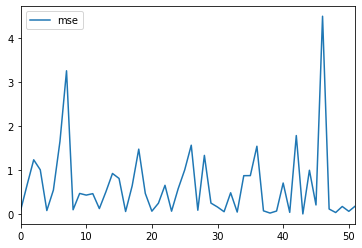

In [21]:
res.plot(y='mse')

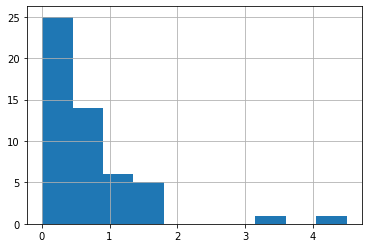

In [22]:
res['mse'].hist()

In [25]:
res_sorted = res.sort_values(by='mse',ascending=False)
res_sorted.head()

,use,meter,n_data,R2,mse
46,Technology/science,3,8748,0.550210,4.491899
7,Entertainment/public assembly,3,138796,0.628268,3.254709
42,Services,2,17564,0.898381,1.785532
6,Entertainment/public assembly,2,240055,0.686833,1.653541
26,Office,3,289434,0.777705,1.566249


In [34]:
res_sorted_new = res_sorted
dtrs_new = dtrs

In [121]:
k = 10 # tree to fix
curr = res_sorted.iloc[k]
curr

use         Office
meter            2
n_data      674002
R2        0.851947
mse         1.0056
Name: 25, dtype: object

In [122]:
# extract by primary use and meter value
sub_df = tbw[(tbw['primary_use']== curr['use']) & (tbw['meter']==curr['meter'])]

X=sub_df[features_list]
y=sub_df['log_meter_reading']

#eliminate points with no temperature
cond = ~X['air_temperature'].isnull() 
print(sum(cond),'datapoints')
X = X[cond]
y = y[cond]

#if len(y)==0:
#    continue        


674002 datapoints


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   43.7s finished


{'min_samples_leaf': 160, 'min_samples_split': 4}


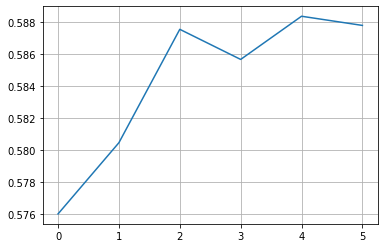

In [124]:
from sklearn.model_selection import GridSearchCV
params = {'min_samples_leaf':np.arange(80,200,20), 'min_samples_split':[4]}

dtr_tune = DecisionTreeRegressor()
gscv = GridSearchCV(dtr_tune, params, cv=5, verbose=1)

gscv.fit(X, y)

print(gscv.best_params_)

mts= np.array(gscv.cv_results_['mean_test_score'])
plt.plot(mts);
plt.grid()
plt.show()

In [125]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.75, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

# fit
print('Fitting model...')
t0 = time()
dtr = DecisionTreeRegressor(min_samples_leaf = gscv.best_params_['min_samples_leaf'],\
                            min_samples_split=gscv.best_params_['min_samples_split'])
dtr.fit(X_train,y_train)
print('Fit in {:.1f}s'.format(time()-t0) )

print('Validating...')
# predict
pred = dtr.predict(X_test)

# validate model
R2 = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
print('R2 :', R2)
print('MSE :', mse)


X_train shape:  (505501, 5)
X_test shape:  (168501, 5)
Fitting model...
Fit in 1.6s
Validating...
R2 : 0.8438008792021776
MSE : 1.0609343673747405


In [127]:
res_sorted.iloc[k,:]

use         Office
meter            2
n_data      674002
R2        0.851947
mse         1.0056
Name: 25, dtype: object

In [128]:
# attach results
res_sorted_new.iloc[k,3] = R2
res_sorted_new.iloc[k,4] = mse
dtrs_new[res_sorted_new.index[k]] = dtr
print('Done')
print('')


Done



In [129]:
res_sorted_new

,use,meter,n_data,R2,mse
46,Technology/science,3,8748,0.736709,2.629403
7,Entertainment/public assembly,3,138796,0.656662,3.006102
42,Services,2,17564,0.898381,1.785532
6,Entertainment/public assembly,2,240055,0.805254,1.028269
26,Office,3,289434,0.815078,1.302926
36,Public services,3,78928,0.837605,1.166264
18,Lodging/residential,2,360378,0.816711,1.127964
28,Other,1,22623,0.872473,1.214322
2,Education,2,1125729,0.853747,1.066914
3,Education,3,606440,0.859646,0.914806


In [130]:
res_sorted_new.to_csv('tuned_tree_of_trees_perf.csv',index=True)

In [131]:
import pickle
with open('tuned_tree_of_trees_191026.pkl','ab') as dbfile:
    pickle.dump(dtrs, dbfile)
